In [14]:
import pandas as pd
import numpy as np
import os
import getpass
import re
import nltk
import tqdm
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
import matplotlib as plt
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras import optimizers

In [15]:
dff = pd.read_csv("Merged_Finall.csv")
dff = dff[dff["Date"] > "2014-01-01"]
temp_dff = dff
dff = dff[["Close", "Open","Low", "High","Volume","FinalScore"]]


scaler = StandardScaler()
scaler = scaler.fit(dff)
scaled_df = scaler.transform(dff)

training_ds = scaled_df[:(int(len(scaled_df) * 0.8))]
test_ds = scaled_df[(int(len(scaled_df) * 0.8)):]

print(f"training dataset contains {len(training_ds)} samples and test dataset contains {len(test_ds)} samples")


training_ds_temp = temp_dff[:(int(len(temp_dff) * 0.8))]
test_ds_temp = temp_dff[(int(len(temp_dff) * 0.8)):]

train_dates = pd.to_datetime(training_ds_temp['Date'])
test_dates = pd.to_datetime(test_ds_temp['Date'])

training dataset contains 1721 samples and test dataset contains 431 samples


In [16]:
def sliding_windows(dataset, future, lookback, label_col):
    
    Features = []
    label = []

    n_future = future 
    n_past = lookback

    for i in range(n_past, len(dataset) - n_future +1):
        Features.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        label.append(dataset[i + n_future - 1:i + n_future, label_col]) #0 means our label class in 1st column.

    Features, label = np.array(Features).astype(np.float32), np.array(label).astype(np.float32)

    print('Features shape == {}.'.format(Features.shape))
    print('label shape == {}.'.format(label.shape))

    return Features, label

In [17]:
future_ = 1
lookback_ = 4

train_ds_windows_X, train_ds_windows_y  = sliding_windows(training_ds, future_, lookback_, 0)
test_ds_windows_X, test_ds_windows_y  = sliding_windows(test_ds, future_, lookback_, 0)

Features shape == (1717, 4, 6).
label shape == (1717, 1).
Features shape == (427, 4, 6).
label shape == (427, 1).


In [18]:
model = Sequential()
model.add(LSTM(800, input_shape=(train_ds_windows_X.shape[1], train_ds_windows_X.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_ds_windows_y.shape[1]))


model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 800)               2582400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 801       
Total params: 2,583,201
Trainable params: 2,583,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
11/11 [==============================] - 1s 62ms/step - loss: 0.1359 - val_loss: 0.3387
Epoch 2/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0156 - val_loss: 0.0642
Epoch 3/100
11/11 [==============================] - 0s 37ms/step - loss: 0.0031 - val_loss: 0.0621
Epoch 4/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0022 - val_loss: 0.0608
Epoch 5/100
11/11 [==============================] - 0s 36ms/step - loss: 0.0014 - val_loss: 0.0759
Epoch 6/100
11/11 [==============================] - 0s 36ms/step - loss: 9.4753e-04 - val_loss: 0.0912
Epoch 7/100
11/11 [==============================] - 0s 36ms/step - loss: 9.3006e-04 - val_loss: 0.0895
Epoch 8/100
11/11 [==============================] - 0s 36ms/step - loss: 9.3485e-04 - val_loss: 0.0872
Epoch 9/100
11/11 [==============================] - 0s 36ms/step - loss: 8.5945e-04 - val_loss: 0.0856
Epoch 10/100
11/11 [==============================] - 0s 36ms/step - loss: 9.3449e-0

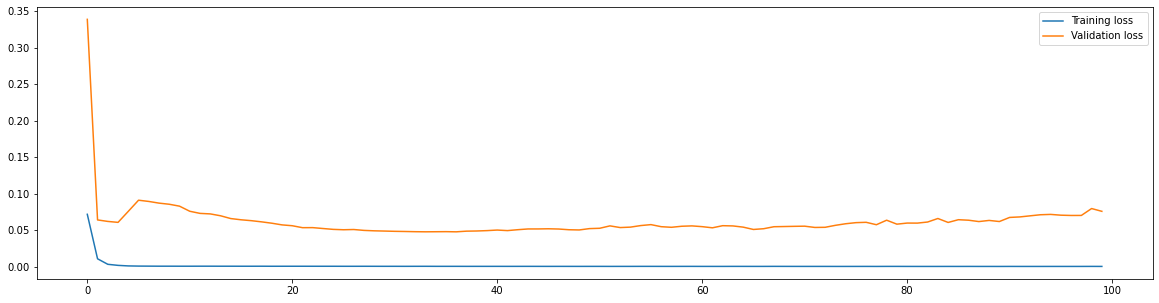

In [19]:
history = model.fit(train_ds_windows_X, train_ds_windows_y, epochs=100, batch_size=128, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [20]:
prediction = model.predict(test_ds_windows_X)

In [21]:
prediction_copies = np.repeat(prediction, test_ds.shape[1], axis=-1)
true_predictions = scaler.inverse_transform(prediction_copies)[:,0]

print(f"The shape of predictions is {true_predictions.shape}")

The shape of predictions is (427,)


In [22]:
df_forecast = pd.DataFrame({'Date':np.array(test_dates[lookback_:]), 'Predictions':true_predictions.flatten(), 'Actual':test_ds_temp[lookback_:]["Close"]})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [23]:
df_forecast

,Date,Predictions,Actual
1973,2018-09-23,6606.153809,6710.630000
1974,2018-09-24,6625.747070,6595.410000
1975,2018-09-25,6580.946777,6446.470000
1976,2018-09-26,6522.949219,6495.000000
1977,2018-09-27,6447.865234,6676.750000
...,...,...,...
2395,2019-11-19,8616.028320,8206.145918
2396,2019-11-20,8563.173828,8027.268243
2397,2019-11-21,8367.893555,7642.749945
2398,2019-11-22,8208.305664,7296.577568


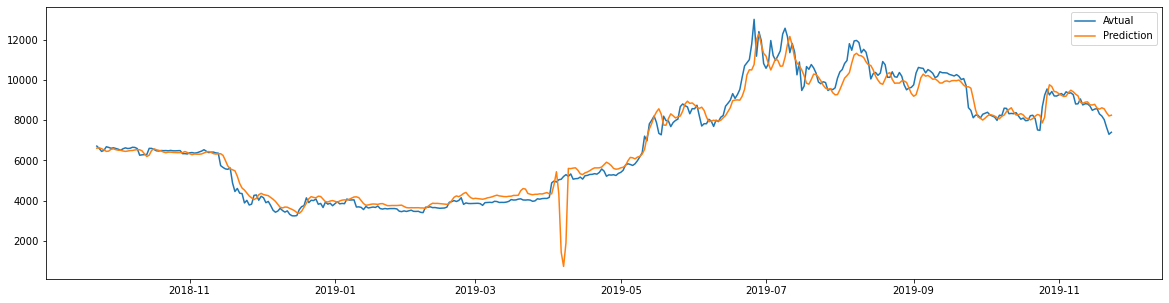

In [24]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(df_forecast['Date'], df_forecast['Actual'], label = "Avtual")
plt.plot(df_forecast['Date'], df_forecast['Predictions'], label = "Prediction")
plt.legend()

In [25]:
merged_df = df_forecast

In [26]:
merged_df["Actual_prev"] = merged_df["Actual"].shift(+1)
merged_df["Pred_prev"] = merged_df["Predictions"].shift(+1)
merged_df = merged_df.dropna()

merged_df['Actual_target'] = merged_df[['Actual','Actual_prev']].apply(lambda x: 1 if x.Actual > x.Actual_prev else 0, axis=1)
merged_df['Pred_target'] = merged_df[['Predictions','Pred_prev']].apply(lambda x: 1 if x.Predictions > x.Pred_prev else 0, axis=1)

act = list(merged_df["Actual_target"])
pred = list(merged_df["Pred_target"])

hit = 0
miss = 0
for i in range(len(act)):
    if act[i] == pred[i]:
        hit+=1
    else:
        miss+=1
print(f"total hits are {hit} and total misses are {miss}")

total hits are 221 and total misses are 205


/tmp/ipykernel_918971/1980677806.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Actual_target'] = merged_df[['Actual','Actual_prev']].apply(lambda x: 1 if x.Actual > x.Actual_prev else 0, axis=1)
/tmp/ipykernel_918971/1980677806.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Pred_target'] = merged_df[['Predictions','Pred_prev']].apply(lambda x: 1 if x.Predictions > x.Pred_prev else 0, axis=1)
